In [6]:
from numpy import sin, cos, pi, exp
import numpy as np
import scipy.signal as sig
import matplotlib.pyplot as plt
from IPython.display import Audio

# Configure default pyplot settings
plt.rcParams["figure.figsize"] = [8.00, 4.5]
plt.rcParams["figure.autolayout"] = True
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.xmargin"] = 0.0

# Enable importing from modules in top-level directory
from sys import path
if path[0] != '..': path.insert(0, '..')


<img src="figures/NTNU_logo_vertical.svg" align="left" style="width: 30%">
<br clear="all" />
<br></br>

# Spectral Leakage and Windowing

* **Course AIS2201 - Signalbehandling**
* **Week 38, 2025**
* **Lecturer: Kai Erik Hoff**


# Topics

* Recap DFT
* Vindusfunksjoner 
* Zero Padding
* Analyse av vindusfunksjoner

## Recap: DFT of a sinusoid

Output()

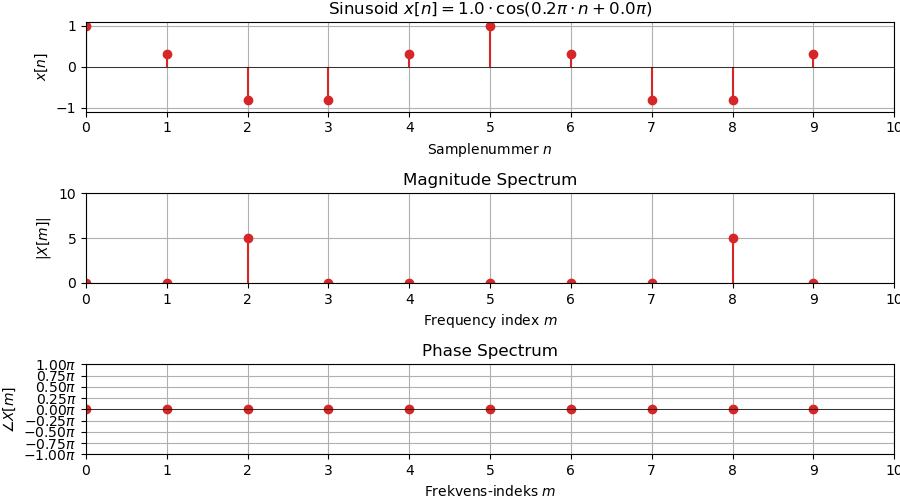

In [3]:
from demos import DFT_Demo
%matplotlib ipympl
DFT_Demo(2);

## Reflections on frequency decomposition


* A DFT ***only*** extracts sinusoidal components at frequencies $f_m = m\cdot \frac{f_s}{N}, \ \ \ m \in \mathbb{Z}$
    * Corresponds to normalized angular frequencies $\hat{\omega}_m = m\cdot \frac{2\pi}{N}, \ \ \ m \in \mathbb{Z}$

* In other words, the DFT operates ***as if*** the signal input signal $x[n]$ is periodic over $N$ samples

* Real-world signals are practically guaranteed not be periodic over $N$ samples.

* What happens when we take a $DFT$ of a signal with frequency components $f \not\in f_m$?

## Code example 1:

* Generate $N=32$ samples of the digital signal $x[n] = \cos\left(\frac{\pi}{10} \cdot n\right)$, and calculate the DFT $X[m]$.
* Display the magnitude spectrum $\left| X[m]\right|$ as a stem plot.

Text(0.5, 0, 'Frequency $f$ (Hz))')

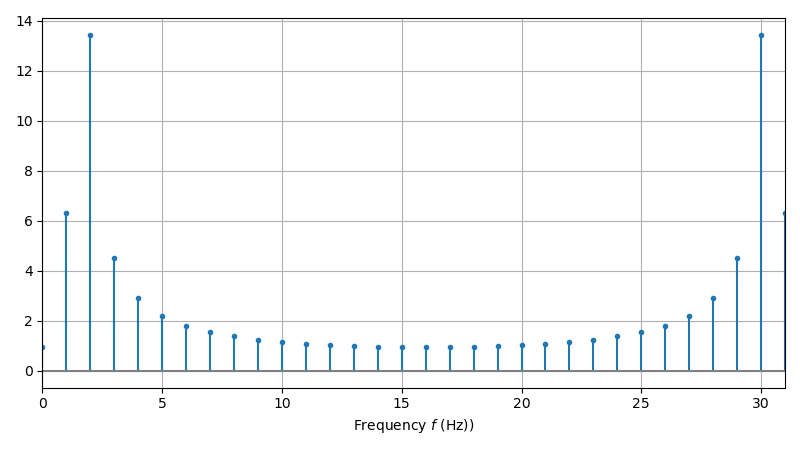

In [5]:
# Liten vinduslengde
N = 32
fs = 32
n = np.arange(N)
xn = cos(pi/10*n)

Xm = np.fft.fft(xn)
plt.figure()
plt.stem(n/N*fs, np.abs(Xm), markerfmt=".", basefmt="grey")
plt.xlabel("Frequency $f$ (Hz))")

# Spectral Leakage



* DFT of $N$ samples from a signal $x[n]$ will in reality find a frequency domain composition which matches exactly those $N$ samples from $x[n]$ using only frequency components from the set:
$$\hat{\omega}_m = \Delta \hat{\omega}\cdot m = 2\pi \frac{m}{N}\ \text{rad/sample}$$
or alternatively:
$$f_m = \Delta f \cdot m = \frac{m}{N} \cdot f_s \ \text{Hz}$$



* If the signal $x[n]$ does contain frequency components $\hat{\omega} \notin \hat{\omega}_m$, spectral leakage will occur
    * The actual frequency content of the signal will "leak out" across multiple frequency samples in $X[m]$
    * The leakage effect will have the largest magnitude for the sample frequency $\hat{\omega}_m$ closest to the actual frequency.

Output()

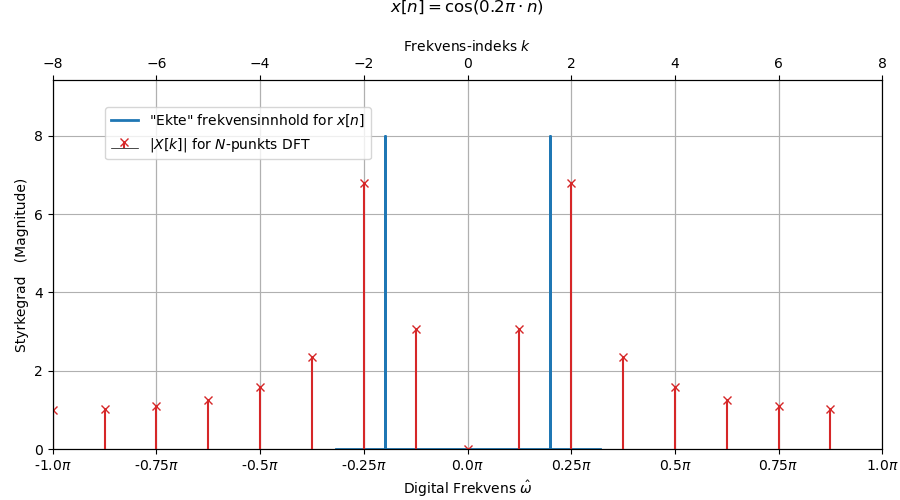

In [7]:
from demos import SpectralLeakageDemo
%matplotlib ipympl
SpectralLeakageDemo(figsize=(9,5)); # Figurstørrelsen kan endres for å tilpasse dokumentvisning.

## Example 1:
* A signal $x(t) = \cos(2\pi\cdot 570 \cdot t)$ is sampled at a constant sampling rate $f_s = 4000Hz$. A signal segment of length $N=256$ samples is used to calculate the DFT $X[m]$, is used to estimate the frequency of the sinusoid $x(t)$ by identifying the most significant frequency component. What is the estimated frequency?

In [12]:
# Simulated example

def x(t):
    return np.cos(2*np.pi*570*t)

fs = 4000
N = 256
n = np.arange(N)

xn = x(n/fs)

Xm = np.fft.rfft(xn)
m_freq = np.argmax(np.abs(Xm))
freq = m_freq/N*fs

print(f"{freq = :f}")

freq = 562.500000


## The reason for spectral leakage

* The root cause for spectral leakage becomes apparent if we reconstruct a continuous-time waveform based on the DFT (treating the DFT as a fourier series).

$$\hat{x}(t) = X[0] + 2\cdot \sum_{m=1}^{N/2} |X[m]| \cdot \cos\left(2\pi \frac{m\cdot f_s}{N}\cdot t + \angle X[m]\right)$$





<img src="figures/Fig1_SpecLeakTimeDomain.png" style="width: 70%; margin-left: 100px" />

* The figure shows reconstructed waveform $\hat{x}(t)$ alongside original waveform $x(t)$ for a 32-point DFT
    * *For simplicity $f_s = N = 32$ in the example*

# Key insights

* An $N$-point DFT of a signal $x[n]$ provides the frequency content of a hypothetical signal $\hat{x}[n]$ which ***is*** periodic over a period of $N$ samles, regardless of whether or not this is true for the actual signal $x[n]$

* Originates from compensating for the "discontinuity" between sample $x[N-1]$ and the next sample in the periodic signal which will be equal to $x[0]$.

* The greater the difference between these two signals, the more pronounced the spectral leakage will be.

* The apparent magnitude of frequency components in the signal will be reduced by up to $-4 \text{ dB}$, a phenomenon known as "scalloping loss"

# Window functions

* A ***window function*** is a useful tool for limiting the effects of spectral leakage.
    * By manipulating the signal segment $x[n], n \in [0, N-1]$ *before* calculating the DFT, we can modify the frequency content towards a more accurate representation
    * The window function $w[n]$ will attribute specific weights to samples in the signal $x[n]$ according to sample number.
    * Truncates samples close to the edges of the window, in order to minimize the discontinuity between $x[N-1]$ and $x[0]$.

# Example: hann window

### $$ w[n] = \begin{cases}
0.5 - 0.5 \cos \left( 2\pi \frac{n}{N} \right) \ \ ,& 0 \leq n <N \\
0, & \text{Otherwise}
\end{cases}$$

<img src="figures/Fig2_HannWindow.png" style="width: 80%; margin-left: 100px" />

## Code example 2:
* Generate $N=32$ samples of the digital signal $x[n] = \cos\left(\frac{\pi}{10} \cdot n\right)$, and calculate the signal's DFT $X[m]$
* Apply weighting of the signal samples $x[n]$ according to a *hann* window function, and calculate the DFT of this modified signal.
* Compare the two DFT magnitudes using a stem plot.

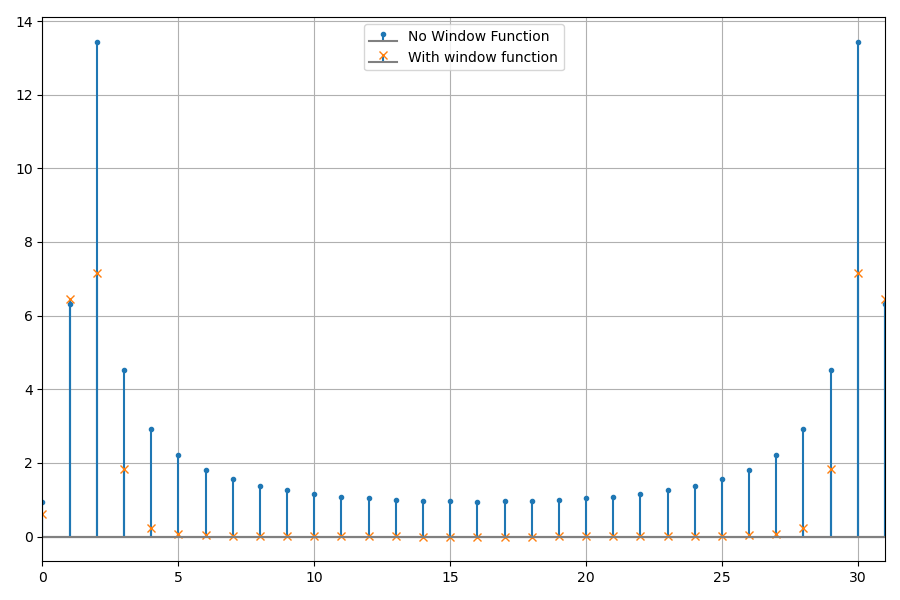

In [12]:
import scipy.signal as sig
N = 32
n = np.arange(N)
xn = cos(pi/10*n)

Xm = np.fft.fft(xn)

wn = 0.5 - 0.5*np.cos(2*np.pi*n/N)
xn_win = xn*wn

Xm_win = np.fft.fft(xn_win)



plt.figure(figsize=(9,6))
plt.stem(n, np.abs(Xm), markerfmt='.C0', basefmt='grey', label="No Window Function")
plt.stem(n, np.abs(Xm_win), markerfmt='xC1', basefmt='grey', label="With window function")
plt.legend()

## Observations on windowing

* Confines the majority of leakage to the true frequency's closest neighbors along the frequency axis.
* Reduces the overall magnitude of the signal
    * Not really a problem, as all frequency components are affected equally


<img src="figures/Fig3-1_Leakage.png" style="width: 80%; margin-left: 100px" />

# Spørsmål?